In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import json
from collections import Counter
from io import BytesIO
import PIL
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import clear_output, Image, display, HTML

In [2]:
batch_size = 250 # batch size

def augment(icons, labels, size):
    aug_icons = []
    aug_labels = []
    for icon, label in zip(icons, labels):
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                aug_labels.append(label)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
            if flip % 2 == 0:
                icon = np.flipud(icon)
    aug_icons = np.asarray(aug_icons) / 255

    return aug_icons, np.asarray(aug_labels)

def load_icons(train_size=0.90, size=28):
    icon_index = json.load(open('icons/index.json'))
    cat_count = Counter(icon['category'] for icon in icon_index)
    cats = [cat for cat, count in cat_count.items() if count > 50]
    cat_to_index = {cat: idx for idx, cat in enumerate(cats)}
    x = []
    y = []
    img_rows, img_cols = size, size
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        cat_idx = cat_to_index.get(icon['category'])
        if cat_idx is None:
            continue
        img_path = 'icons/png%d/%s.png' % (size, icon['name'])
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
        y.append(cat_idx)
    target_size = len(x) - (len(x) % batch_size)
    x = x[:target_size]
    y = y[:target_size]
    x = np.asarray(x)
    y = np.asarray(y)
    train_size = int(train_size * x.shape[0])
    train_size -= train_size % batch_size
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
    x_train, y_train = augment(x_train, y_train, size=size)
    x_test, y_test = augment(x_test, y_test, size=size)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_icons(size=32)
x_train.shape

/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(84000, 32, 32, 1)

In [3]:
batch_size = 250
latent_space_depth = 128

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [4]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels, num_pixels, 1))
    channels = 4
    x = pixels
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x) 
    x = Flatten()(x)
    encoder_hidden = Dense(latent_space_depth, name='encoder_hidden')(x)

    z_mean = Dense(latent_space_depth, activation='linear', name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear', name='z_log_var')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    up_samp0 = UpSampling2D((2, 2))
    up_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
    up_samp1 = UpSampling2D((2, 2))
    up_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')
    up_samp2 = UpSampling2D((2, 2))
    up_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')
    up_samp3 = UpSampling2D((2, 2))
    up_conv4 = Conv2D(4, (3, 3), activation='relu', padding='same')
    up_samp4 = UpSampling2D((2, 2))
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    decoder_in = Input(shape=(latent_space_depth,))
    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    d_x = up_samp0(d_x)
    d_x = up_conv1(d_x)
    d_x = up_samp1(d_x)
    d_x = up_conv2(d_x)
    d_x = up_samp2(d_x)
    d_x = up_conv3(d_x)
    d_x = up_samp3(d_x)
    d_x = up_conv4(d_x)
    d_x = up_samp4(d_x)
    decoder_out= decoded(d_x)

    decoder = Model(decoder_in, decoder_out)    

    a_x = Reshape((1, 1, latent_space_depth))(z)
    a_x = up_samp0(a_x)
    a_x = up_conv1(a_x)
    a_x = up_samp1(a_x)
    a_x = up_conv2(a_x)
    a_x = up_samp2(a_x)
    a_x = up_conv3(a_x)
    a_x = up_samp3(a_x)
    a_x = up_conv4(a_x)
    a_x = up_samp4(a_x)
    outputs= decoded(a_x)
    
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 4)    40          <tensorflow.python.keras.engine.i
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    20          <tensorflow.python.keras.engine.i
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 8)    0           <tensorflow.python.keras.layers.c
                                     

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((84000, 32, 32, 1), (84000,), (12000, 32, 32, 1), (12000,))

In [6]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 84000 samples, validate on 12000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
84000/84000 [==============================] - 7s 78us/sample - loss: 527.8878 - KL_loss: 4.4031 - reconstruction_loss: 523.4847 - val_loss: 474.6179 - val_KL_loss: 9.5615 - val_reconstruction_loss: 465.0564
Epoch 2/100
84000/84000 [==============================] - 6s 66us/sample - loss: 456.5155 - KL_loss: 13.0745 - reconstruction_loss: 443.4408 - val_loss: 439.6615 - val_KL_loss: 15.8762 - val_reconstruction_loss: 423.7852
Epoch 3/100
84000/84000 [==============================] - 6s 66us/sample - loss: 432.3736 - KL_loss: 16.6229 - reconstruction_loss: 415.7508 - val_loss: 426.6772 - val_KL_loss: 17.9368 - val_reconstruction_loss: 408.7404
Epoch 4/100
84000/84000 [==============================] - 6s 66us/sample - loss: 422.5025 - KL_loss: 18.2540 - reconstruction_loss: 404.2486 - val_loss: 419.1864 - val_KL_loss: 18.8184 - val_reconstruction_loss: 400.3679
Epoch 5/100
8400

84000/84000 [==============================] - 6s 69us/sample - loss: 385.5835 - KL_loss: 28.3908 - reconstruction_loss: 357.1927 - val_loss: 386.8962 - val_KL_loss: 28.6135 - val_reconstruction_loss: 358.2827
Epoch 37/100
84000/84000 [==============================] - 6s 66us/sample - loss: 385.4035 - KL_loss: 28.4356 - reconstruction_loss: 356.9678 - val_loss: 387.4551 - val_KL_loss: 28.6496 - val_reconstruction_loss: 358.8055
Epoch 38/100
84000/84000 [==============================] - 6s 66us/sample - loss: 385.1250 - KL_loss: 28.5170 - reconstruction_loss: 356.6079 - val_loss: 386.4197 - val_KL_loss: 28.0453 - val_reconstruction_loss: 358.3744
Epoch 39/100
84000/84000 [==============================] - 6s 65us/sample - loss: 385.0418 - KL_loss: 28.5675 - reconstruction_loss: 356.4742 - val_loss: 386.2156 - val_KL_loss: 28.4732 - val_reconstruction_loss: 357.7424
Epoch 40/100
84000/84000 [==============================] - 5s 65us/sample - loss: 384.7524 - KL_loss: 28.6630 - reconstr

Epoch 73/100
84000/84000 [==============================] - 5s 65us/sample - loss: 380.4495 - KL_loss: 30.2859 - reconstruction_loss: 350.1637 - val_loss: 381.8731 - val_KL_loss: 30.0447 - val_reconstruction_loss: 351.8284
Epoch 74/100
84000/84000 [==============================] - 6s 66us/sample - loss: 380.4414 - KL_loss: 30.3026 - reconstruction_loss: 350.1388 - val_loss: 381.8281 - val_KL_loss: 30.5589 - val_reconstruction_loss: 351.2693
Epoch 75/100
84000/84000 [==============================] - 6s 66us/sample - loss: 380.2301 - KL_loss: 30.3603 - reconstruction_loss: 349.8697 - val_loss: 382.0810 - val_KL_loss: 30.3361 - val_reconstruction_loss: 351.7449
Epoch 76/100
84000/84000 [==============================] - 5s 65us/sample - loss: 380.2993 - KL_loss: 30.3564 - reconstruction_loss: 349.9430 - val_loss: 381.8607 - val_KL_loss: 30.4089 - val_reconstruction_loss: 351.4518
Epoch 77/100
84000/84000 [==============================] - 6s 66us/sample - loss: 380.0482 - KL_loss: 30.43

In [7]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
print(random_number)

[[ 6.06835343e-01  1.91058617e-01 -1.40788183e+00 -1.41750652e-01
   5.07534972e-01 -9.44030837e-01 -9.55252809e-01  5.31362529e-02
   6.51402283e-01  1.57435586e+00  1.37340983e-01  9.24334054e-01
  -4.02060952e-01  7.12333870e-01 -5.03522585e-01 -1.54297357e+00
   7.74471610e-01 -9.70721588e-01 -5.37236722e-01 -2.77129109e-01
  -1.26063062e+00  1.36071660e+00 -7.12840403e-01 -3.85900032e-01
   1.70608694e+00  1.22379386e+00 -9.84688669e-01 -1.59338742e+00
   6.84168394e-01  5.49786690e-01 -8.28922412e-01  4.71763302e-01
  -3.83961810e-01  1.31258228e+00  1.80854457e+00 -8.38596272e-04
   2.88404581e-01  6.18797662e-01  5.19285672e-01  1.58447224e+00
  -2.11856327e-01  2.09127445e-01 -1.76076552e-01 -1.15476224e+00
  -8.14503928e-02 -1.47213353e+00 -6.10405521e-01 -1.16160228e+00
  -2.11061131e+00  1.64451416e+00  6.02874223e-01 -2.06802318e+00
   9.39693269e-01  5.60136699e-03  5.73367421e-01 -1.22151198e-02
   1.03833185e+00  9.46083315e-01 -5.62356431e-01 -2.60494702e-01
   1.52941

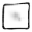

In [8]:
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))


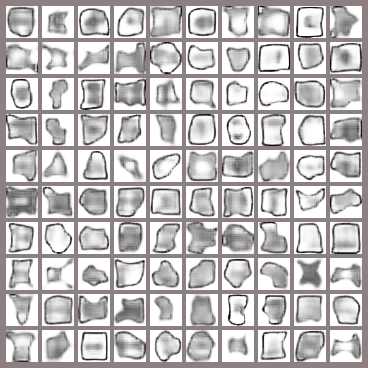

In [9]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

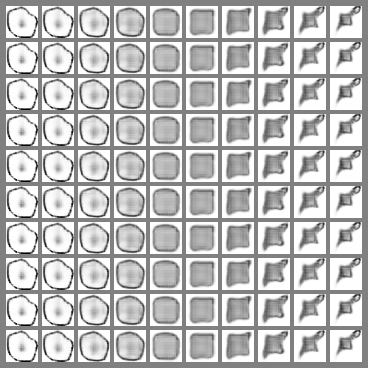

In [10]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[: 1] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
#        vec[: 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [11]:
vec.shape

(1, 128)